# CSCG for counterfactual causal reasoning through episodic memories
Based on https://www.nature.com/articles/s41467-021-22559-5

Code at: http://github.com/vicariousinc/naturecomm_cscg



**Clone the repo from github, Install the necessary libraries**

In [104]:
import sys, os
if not os.path.exists('naturecomm_cscg'):
  print("Cloning naturecomm_cscg repo from github.com/vicariousinc")
  os.system("git clone http://github.com/vicariousinc/naturecomm_cscg")

!pip install cairocffi
!pip install python-igraph==0.9.8

***Import the needed python modules***

In [106]:
sys.path.append('naturecomm_cscg')
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room, forwardE_mp, backtraceE, backtrace, forward_mp, rargmax, forwardE, backtraceE
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")

In [107]:
import numpy as np
np.random.seed(52)

In [108]:
## A Few utility functions

def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True) ##normalized state transition probabilities

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(chmm.n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]

    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )
    print(v)
    return out, states


def get_mess_fwd(chmm, x, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    T = T.mean(0, keepdims=True)
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, x*0 , store_messages=True
    )
    return mess_fwd, E, T


def place_field(mess_fwd, rc, clone):
    assert mess_fwd.shape[0] == rc.shape[0] and clone < mess_fwd.shape[1]
    field = np.zeros(rc.max(0) + 1)
    count = np.zeros(rc.max(0) + 1, int)
    for t in range(mess_fwd.shape[0]):
        r, c = rc[t]
        field[r, c] += mess_fwd[t, clone]
        count[r, c] += 1
    count[count == 0] = 1
    return field / count


# Quickly train a CSCG on a rectangular aliased room that has only 4 unique observations

In [39]:
def generate_sequence(sequence_length):
    
    transition_matrix = np.array([
        [0.0, 0.5, 0.5, 0.0, 0.0, 0.0],   # Transition probabilities from S
        [0.0, 0.0, 0.0, 0.5, 0.5, 0.0],   # Transition probabilities from L
        [0.0, 0.0, 0.0, 0.5, 0.5, 0.0],   # Transition probabilities from NL
        [0.6, 0.0, 0.0, 0.0, 0.0, 0.4],   # Transition probabilities from T  when arriving from L
        [0.55, 0.0, 0.0, 0.0, 0.0, 0.45],   # Transition probabilities from C  when arriving from L
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    # Transition probabilities from P
    ])

    observations = ['S', 'L', 'NL', 'T', 'C', 'P']
    sequence = np.empty(sequence_length, dtype=int)

    current_state_index = 0
    for i in range(sequence_length):
        sequence[i] = current_state_index
        if (current_state_index==3 and sequence[i-1]==2):
          next_state_probs = [0.2, 0.0, 0.0, 0.0, 0.0, 0.8]
        elif (current_state_index==4 and sequence[i-1]==2):
          next_state_probs = [0.1, 0.0, 0.0, 0.0, 0.0, 0.9]
        else:
          next_state_probs = transition_matrix[current_state_index]
        #print('current state:', observations[current_state_index])
        #print('probs:', next_state_probs)
        next_state_index = np.random.choice(len(next_state_probs), p=next_state_probs)

        current_state_index = next_state_index

    return sequence

In [781]:
def generate_sequence_1(sequence_length):
    
    transition_matrix = np.array([
        [0.0, 0.5, 0.3, 0.2, 0.0],   # Transition probabilities from S
        [0.0, 0.0, 0.4, 0.6, 0.0],   # Transition probabilities from L
        [0.6, 0.0, 0.0, 0.0, 0.4],   # Transition probabilities from T  when arriving from L
        [0.4, 0.0, 0.0, 0.0, 0.6], # Transition probabilities from C  when arriving from L
        [1.0, 0.0, 0.0, 0.0, 0.0]    # Transition probabilities from P
    ])

    observations = ['S', 'L', 'T', 'C', 'P']
    sequence = np.empty(sequence_length, dtype=int)

    current_state_index = 0
    for i in range(sequence_length):
        sequence[i] = current_state_index
        if (current_state_index==2 and sequence[i-1]==1):
          next_state_probs = [0.1, 0.0, 0.0, 0.0, 0.9]
        elif (current_state_index==3 and sequence[i-1]==1):
          next_state_probs = [0.7, 0.0, 0.0, 0.0, 0.3]
        else:
          next_state_probs = transition_matrix[current_state_index]
        #print('current state:', observations[current_state_index])
        #print('probs:', next_state_probs)
        next_state_index = np.random.choice(len(next_state_probs), p=next_state_probs)

        current_state_index = next_state_index

    return sequence

In [109]:
def generate_sequence_simplified(sequence_length):
    
    transition_matrix = np.array([
        [0.0, 0.5, 0.5, 0.0],   # Transition probabilities from S
        [0.0, 0.0, 1.0, 0.0],   # Transition probabilities from L
        [0.3, 0.0, 0.0, 0.7],   # Transition probabilities from T  when arriving from S
        [1.0, 0.0, 0.0, 0.0]    # Transition probabilities from P
    ])

    observations = ['S', 'L', 'T', 'P']
    sequence = np.empty(sequence_length, dtype=int)

    current_state_index = 0
    for i in range(sequence_length):
        sequence[i] = current_state_index
        if (current_state_index==2 and sequence[i-1]==1):
          next_state_probs = [0.6, 0.0, 0.0, 0.4]
        else:
          next_state_probs = transition_matrix[current_state_index]
        #print('current state:', observations[current_state_index])
        #print('probs:', next_state_probs)
        next_state_index = np.random.choice(len(next_state_probs), p=next_state_probs)

        current_state_index = next_state_index

    return sequence

In [771]:
def generate_sequence_1_3(sequence_length):
    
    transition_matrix = np.array([
        [0.0, 0.5, 0.3, 0.2, 0.0, 0.0],   # Transition probabilities from S
        [0.0, 0.0, 0.4, 0.6, 0.0, 0.0],   # Transition probabilities from L
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],   # Transition probabilities from T  when arriving from L
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], # Transition probabilities from C  when arriving from L
        [0.1, 0.0, 0.0, 0.0, 0.0, 0.9],    # Transition probabilities from A
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # Transition probabilities from P
    ])

    observations = ['S', 'L', 'T', 'C', 'A', 'P']
    sequence = np.empty(sequence_length, dtype=int)

    current_state_index = 0
    for i in range(sequence_length):
        sequence[i] = current_state_index
        if (current_state_index==4 and sequence[i-1]==2 and sequence[i-2]==1):
          next_state_probs = [0.8, 0.0, 0.0, 0.0, 0.0, 0.2]
        elif (current_state_index==4 and sequence[i-1]==3 and sequence[i-2]==1):
          next_state_probs = [0.6, 0.0, 0.0, 0.0, 0.0, 0.4]
        else:
          next_state_probs = transition_matrix[current_state_index]
        #print('current state:', observations[current_state_index])
        #print('probs:', next_state_probs)
        next_state_index = np.random.choice(len(next_state_probs), p=next_state_probs)

        current_state_index = next_state_index

    return sequence

In [270]:
def generate_sequence_0(sequence_length):
    
    transition_matrix = np.array([
        [0.0, 0.4, 0.4, 0.0, 0.2, 0.0],   # Transition probabilities from S
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],   # Transition probabilities from L
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],   # Transition probabilities from NL
        [0.8, 0.0, 0.0, 0.0, 0.0, 0.2],   # Transition probabilities from T  when arriving from L
        [0.1, 0.0, 0.0, 0.0, 0.0, 0.9],   # Transition probabilities from C  when arriving from L
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    # Transition probabilities from P
    ])

    observations = ['S', 'L', 'NL', 'T', 'C', 'P']
    sequence = np.empty(sequence_length, dtype=int)

    current_state_index = 0
    for i in range(sequence_length):
        sequence[i] = current_state_index
        if (current_state_index==3 and sequence[i-1]==2):
          next_state_probs = [0.3, 0.0, 0.0, 0.0, 0.0, 0.7]
        #if (current_state_index==4 and sequence[i-1]==2):
        #  next_state_probs = [0.1, 0.0, 0.0, 0.0, 0.0, 0.9]
        else:
          next_state_probs = transition_matrix[current_state_index]
        #print('current state:', observations[current_state_index])
        #print('probs:', next_state_probs)
        next_state_index = np.random.choice(len(next_state_probs), p=next_state_probs)

        current_state_index = next_state_index

    return sequence

In [413]:
def generate_sequence_0_1(sequence_length):
    
    transition_matrix = np.array([
        [0.0, 0.4, 0.4, 0.0, 0.2, 0.0],   # Transition probabilities from S
        [0.0, 0.0, 0.0, 0.4, 0.6, 0.0],   # Transition probabilities from L
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],   # Transition probabilities from NL
        [0.8, 0.0, 0.0, 0.0, 0.0, 0.2],   # Transition probabilities from T  when arriving from L
        [0.1, 0.0, 0.0, 0.0, 0.0, 0.9],   # Transition probabilities from C  when arriving from L
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    # Transition probabilities from P
    ])

    observations = ['S', 'L', 'NL', 'T', 'C', 'P']
    sequence = np.empty(sequence_length, dtype=int)

    current_state_index = 0
    for i in range(sequence_length):
        sequence[i] = current_state_index
        if (current_state_index==3 and sequence[i-1]==2):
          next_state_probs = [0.3, 0.0, 0.0, 0.0, 0.0, 0.7]
        elif (current_state_index==4 and sequence[i-1]==2):
          next_state_probs = [0.4, 0.0, 0.0, 0.0, 0.0, 0.6]
        else:
          next_state_probs = transition_matrix[current_state_index]
        #print('current state:', observations[current_state_index])
        #print('probs:', next_state_probs)
        next_state_index = np.random.choice(len(next_state_probs), p=next_state_probs)

        current_state_index = next_state_index

    return sequence

In [610]:
def generate_sequence_2(sequence_length):
    
    transition_matrix = np.array([
        [0.0, 0.0, 0.4, 0.6, 0.0],   # Transition probabilities from L
        [0.0, 0.0, 0.6, 0.4, 0.0],   # Transition probabilities from NL
        [0.25, 0.25, 0.0, 0.0, 0.5],   # Transition probabilities from T  when arriving from L
        [0.2, 0.2, 0.0, 0.0, 0.6],   # Transition probabilities from C  when arriving from L
        [0.5, 0.5, 0.0, 0.0, 0.0]    # Transition probabilities from P
    ])

    observations = ['L', 'NL', 'T', 'C', 'P']
    sequence = np.empty(sequence_length, dtype=int)

    current_state_index = 0
    for i in range(sequence_length):
        sequence[i] = current_state_index
        if (current_state_index==2 and sequence[i-1]==1):
          next_state_probs = [0.1, 0.1, 0.0, 0.0, 0.8]
        if (current_state_index==3 and sequence[i-1]==1):
          next_state_probs = [0.05, 0.05, 0.0, 0.0, 0.9]
        else:
          next_state_probs = transition_matrix[current_state_index]
        #print('current state:', observations[current_state_index])
        #print('probs:', next_state_probs)
        next_state_index = np.random.choice(len(next_state_probs), p=next_state_probs)

        current_state_index = next_state_index

    return sequence

In [6]:
from collections import defaultdict
import numpy as np

def calculate_transition_probabilities(sequence, num_states=4):
    # Initialize a matrix to count transitions between states
    transition_counts = np.zeros((num_states, num_states), dtype=int)
    
    # Separate counters for specific transitions (e.g., T to P based on previous state)
    special_transition_counts = {
        'T_from_L_to_P': 0, 
        'T_from_S_to_P': 0, 
        'T_from_L_total': 0, 
        'T_from_S_total': 0
    }
    
    # Count transitions between states, tracking previous state
    for i in range(1, len(sequence) - 1):
        previous_state = sequence[i - 1]
        current_state = sequence[i]
        next_state = sequence[i + 1]
        
        # Count the general transition
        transition_counts[current_state][next_state] += 1
        
        # Special handling for transitions from T to P based on previous state
        if current_state == 2 and next_state == 3:  # T to P
            if previous_state == 1:  # Arrived at T from L
                special_transition_counts['T_from_L_to_P'] += 1
                special_transition_counts['T_from_L_total'] += 1
            elif previous_state == 0:  # Arrived at T from S
                special_transition_counts['T_from_S_to_P'] += 1
                special_transition_counts['T_from_S_total'] += 1
        elif current_state == 2:  # T but not transitioning to P
            if previous_state == 1:
                special_transition_counts['T_from_L_total'] += 1
            elif previous_state == 0:
                special_transition_counts['T_from_S_total'] += 1

    # Calculate the general transition probabilities
    transition_matrix = np.zeros((num_states, num_states))
    for from_state in range(num_states):
        from_state_total = np.sum(transition_counts[from_state])
        if from_state_total > 0:
            transition_matrix[from_state] = transition_counts[from_state] / from_state_total

    # Calculate the conditional probabilities for T to P based on previous state
    prob_T_from_L_to_P = (special_transition_counts['T_from_L_to_P'] / special_transition_counts['T_from_L_total']
                          if special_transition_counts['T_from_L_total'] > 0 else 0)
    prob_T_from_S_to_P = (special_transition_counts['T_from_S_to_P'] / special_transition_counts['T_from_S_total']
                          if special_transition_counts['T_from_S_total'] > 0 else 0)
    
    # Print or return conditional probabilities along with the transition matrix
    print("Empirical Transition Matrix:")
    print(transition_matrix)
    print(f"\nConditional Probability of T to P when arriving from L: {prob_T_from_L_to_P:.2f}")
    print(f"Conditional Probability of T to P when arriving from S: {prob_T_from_S_to_P:.2f}")

    return transition_matrix, prob_T_from_L_to_P, prob_T_from_S_to_P

# Example usage
length = 10000
sequence = generate_sequence_simplified(length)
transition_matrix, prob_T_from_L_to_A, prob_T_from_S_to_A = calculate_transition_probabilities(sequence)

Empirical Transition Matrix:
[[0.         0.51102386 0.48897614 0.        ]
 [0.         0.         1.         0.        ]
 [0.49184783 0.         0.         0.50815217]
 [1.         0.         0.         0.        ]]

Conditional Probability of T to P when arriving from L: 0.30
Conditional Probability of T to P when arriving from S: 0.72


In [ ]:
#check that the sequence generation f. works correctly
from collections import defaultdict

def calculate_transition_probabilities(sequence, num_states=4):
    # Initialize a matrix to count transitions between states
    transition_counts = np.zeros((num_states, num_states), dtype=int)
    
    # Separate counters for specific transitions (e.g., T to A based on previous state)
    special_transition_counts = {'T_from_L_to_A': 0, 'T_from_S_to_A': 0, 'T_from_L_total': 0, 'T_from_S_total': 0}
    
    # Count transitions between states, tracking previous state
    for i in range(1, len(sequence) - 1):
        previous_state = sequence[i - 1]
        current_state = sequence[i]
        next_state = sequence[i + 1]
        
        # Count the general transition
        transition_counts[current_state][next_state] += 1
        
        # Special handling for transitions from T to A based on previous state
        if current_state == 2 and next_state == 3:  # T to A
            if previous_state == 1:  # Arrived at T from L
                special_transition_counts['T_from_L_to_A'] += 1
                special_transition_counts['T_from_L_total'] += 1
            elif previous_state == 0:  # Arrived at T from S
                special_transition_counts['T_from_S_to_A'] += 1
                special_transition_counts['T_from_S_total'] += 1
        elif current_state == 2:  # T but not transitioning to A
            if previous_state == 1:
                special_transition_counts['T_from_L_total'] += 1
            elif previous_state == 0:
                special_transition_counts['T_from_S_total'] += 1

    # Calculate the general transition probabilities
    transition_matrix = np.zeros((num_states, num_states))
    
    for from_state in range(num_states):
        from_state_total = np.sum(transition_counts[from_state])
        if from_state_total > 0:
            transition_matrix[from_state] = transition_counts[from_state] / from_state_total

    # Calculate the conditional probabilities for T to A based on previous state
    prob_T_from_L_to_A = (special_transition_counts['T_from_L_to_A'] / special_transition_counts['T_from_L_total']
                          if special_transition_counts['T_from_L_total'] > 0 else 0)
    prob_T_from_S_to_A = (special_transition_counts['T_from_S_to_A'] / special_transition_counts['T_from_S_total']
                          if special_transition_counts['T_from_S_total'] > 0 else 0)
    
    # Print or return conditional probabilities along with the transition matrix
    print("Empirical Transition Matrix:")
    print(transition_matrix)
    print(f"\nConditional Probability of T to A when arriving from L: {prob_T_from_L_to_A:.2f}")
    print(f"Conditional Probability of T to A when arriving from S: {prob_T_from_S_to_A:.2f}")

    return transition_matrix, prob_T_from_L_to_A, prob_T_from_S_to_A

# Example usage
length = 10000
sequence = generate_sequence(length)
transition_matrix, prob_T_from_L_to_A, prob_T_from_S_to_A = calculate_transition_probabilities(sequence)

Empirical Transition Matrix:
[[0.         0.51413109 0.48586891 0.        ]
 [0.         0.         1.         0.        ]
 [0.5082657  0.         0.         0.4917343 ]
 [1.         0.         0.         0.        ]]

Conditional Probability of T to A when arriving from L: 0.29
Conditional Probability of T to A when arriving from S: 0.70


In [53]:
# Generate data and train a CSCG.

n_emissions = 4
length =10000
#sequence, actions = generate_sequence_w_actions(300)
sequence = generate_sequence_simplified(length)
actions = np.full(length, 0)
x, a = sequence, actions

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
chmm = CHMM(n_clones=n_clones, pseudocount=18e-3, x=x, a=a, seed=44)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=500)  # Training   use n_iter=1000 for better training


Average number of clones: 70.0


 72%|███████▏  | 358/500 [01:12<00:28,  4.91it/s, train_bps=0.629]


In [62]:
# Generate data and train a CSCG with actions

n_emissions = 4
length =1800
#sequence, actions = generate_sequence_w_actions(300)
sequence = generate_sequence_simplified(length)
actions = np.full(length, 0)

#add actions
for i in range(len(sequence[:-1])):
    if sequence[i]==0 and sequence[i+1]==1: #when I go from Start to Lunch
        actions[i] = 1
x, a = sequence, actions

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
chmm = CHMM(n_clones=n_clones, pseudocount=12e-4, x=x, a=a, seed=44)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=500)  # Training   use n_iter=1000 for better training

Average number of clones: 70.0


100%|██████████| 500/500 [00:20<00:00, 24.67it/s, train_bps=0.296]


In [184]:
# Generate data and train a CSCG with all actions

n_emissions = 4
length =1800
#sequence, actions = generate_sequence_w_actions(300)
sequence = generate_sequence_simplified(length)
actions = np.full(length, 0)

#add actions
for i in range(len(sequence[:-1])):
    if sequence[i]==0 and sequence[i+1]==1: #when I go from Start to Lunch
        actions[i] = 1
    if sequence[i]==2 and sequence[i+1]==3: #when I go from Train to Plane
        actions[i] = 1
x, a = sequence, actions

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
chmm = CHMM(n_clones=n_clones, pseudocount=12e-4, x=x, a=a, seed=44)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=500)  # Training   use n_iter=1000 for better training

Average number of clones: 70.0


100%|██████████| 500/500 [00:19<00:00, 25.19it/s, train_bps=0.00721]


In [633]:
for i in range(len(sequence[:-1])):
    if sequence[i]==0 and sequence[i+1]==1:
        actions[i] = 1
    if ((sequence[i]==1 or sequence[i]==2) and sequence[i+1]==4): #when i go from Start to Lunch
        actions[i] = 1
actions[50:100], sequence[50:100]

(array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0]),
 array([5, 0, 2, 3, 5, 0, 1, 4, 0, 1, 4, 5, 0, 2, 3, 5, 0, 2, 3, 5, 0, 2,
        3, 5, 0, 1, 4, 5, 0, 2, 4, 5, 0, 2, 3, 5, 0, 1, 4, 5, 0, 2, 4, 5,
        0, 1, 4, 5, 0, 2]))

In [ ]:
cmap=cm.Spectral
v = np.unique(states)
node_labels = np.arange(x.max() + 1).repeat(chmm.n_clones)[v]
colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
states = chmm.decode(x, a)[1]

v = np.unique(states)
v

NameError: name 'states' is not defined

In [9]:
sequence[:20]

array([0, 2, 4, 3, 0, 1, 3, 0, 2, 4, 3, 0, 2, 4, 3, 0, 1, 3, 0, 2])

[ 15  51  90 195 228]


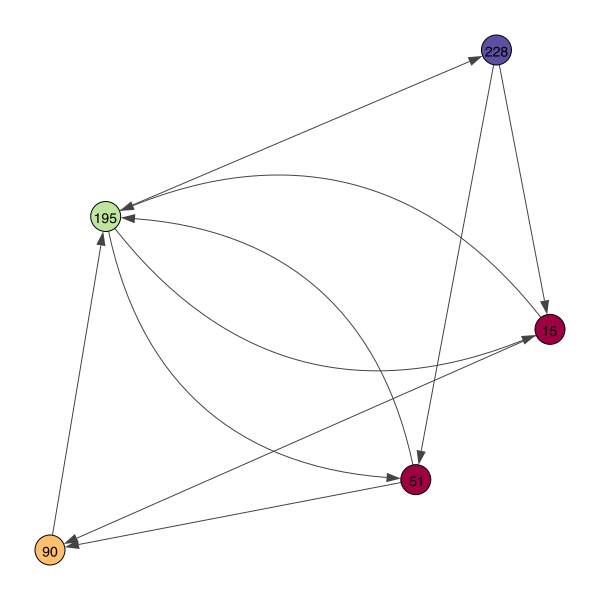

In [111]:
# Plot graph without viterbi
graph, states = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf"
)
graph

(array([1464.,   61.,   25.,   15.,   13.,    7.,    4.,    4.,    3.,
           2.]),
 array([ 0.       ,  4.5158677,  9.031735 , 13.547603 , 18.06347  ,
        22.579338 , 27.095205 , 31.611073 , 36.12694  , 40.642807 ,
        45.158676 ], dtype=float32),
 <BarContainer object of 10 artists>)

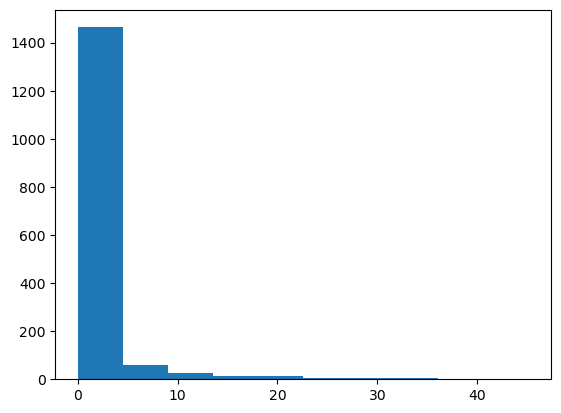

In [154]:
plt.hist(np.unique(chmm.C))

In [187]:
# Consolidate learning. Takes a few seconds
#chmm.pseudocount = .5
chmm.learn_viterbi_T(x, a, n_iter=100)

  2%|▏         | 2/100 [00:00<00:06, 14.40it/s, train_bps=0.00613]


[0.5797986, 0.00612535, 0.00612535]

[ 51  90 195 228]


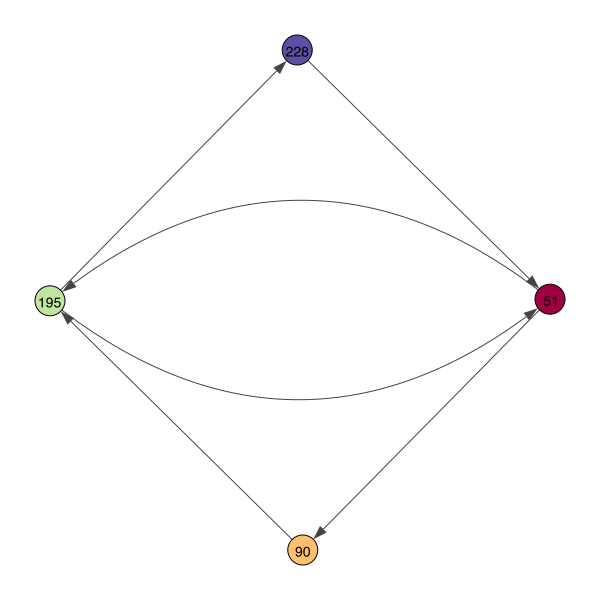

In [188]:
# Visualize the learned, consolidated CSCG.

graph, states = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf"
)

graph
# Look for the correspondence between the graph and the original layout of the rooom in Figure 1
# Node colors correspond to the observations from the room. Node numbers are the clone numbers.

In [69]:
chmm.C.shape

(2, 280, 280)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_graph_probs(
    chmm, x, a, output_file, cmap=plt.cm.Spectral, multiple_episodes=False, vertex_size=30, edge_color='black', marked_transition=None
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    
    # Normalize the transition matrix to get state transition probabilities
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)  # normalized state transition probabilities
    
    # Find the positions of nodes 198 and 217 in the array `v`
    #index_198 = np.where(v == 198)[0][0]  # Get the index of node 198 in `v`
    #index_217 = np.where(v == 217)[0][0]  # Get the index of node 217 in `v`

    # Use these positions to get the transition probability from `A`
    #transition_prob_198_to_217 = A[index_198, index_217]
    #print(f"Transition probability from node 198 to node 217: {transition_prob_198_to_217:.4f}")


    # Create graph using adjacency matrix (A > 0 ensures there's a transition)
    g = igraph.Graph.Adjacency((A > 0).tolist())
    
    # Assign node labels based on the unique states and clones
    node_labels = np.arange(x.max() + 1).repeat(chmm.n_clones)[v]
    max_label = node_labels.max()

    # Define new categories: Lunch, Non-Lunch, Train, Cab, Plane
    categories = [ 'S', 'Lunch', 'Train', 'Cab', 'Airport', 'Plane']
    category_ranges = np.linspace(0, max_label, len(categories))
    category_x_coords = {label: i * 5000 for i, label in enumerate(categories)}
    category_counts = {label: 0 for label in categories}
    
    # Set y-offsets to adjust the y-coordinate per category
    train_y_offset = -1
    cab_y_offset = -1

    # Determine which category each node belongs to based on their clone number
    node_categories = np.digitize(node_labels, category_ranges) - 1

    # Initialize layout
    layout = []
    for idx, nl in enumerate(sorted(node_labels)):
        category = categories[node_categories[idx]]
        x_coord = category_x_coords[category]

        # Adjust y-coordinates based on category and count
        if category == "Train":
            y_coord = train_y_offset + (category_counts[category] * -1)
        elif category == "Cab":
            y_coord = cab_y_offset + (category_counts[category] * -1)
        else:
            y_coord = category_counts[category] * -1
        if category == "Lunch":
            y_coord += 0.5
        elif category == "Non-Lunch":
            #x_coord += 5
            y_coord -= 0.5

        category_counts[category] -= 2
        layout.append((x_coord, y_coord))

    # Assign edge labels for transition probabilities
    for e in g.es:
        source = e.source
        target = e.target
        e['label'] = f"p={A[source, target]:.2f}"  # label with probability

    # Plot the graph
    out = igraph.plot(
        g,
        output_file,
        layout=layout,
        vertex_color=[cmap(nl / max_label)[:3] for nl in sorted(node_labels)],
        vertex_label=sorted(v),  # Ensure the labels are also sorted in numerical order
        vertex_size=vertex_size,
        margin=50,
        #edge_color=edge_colors,
        bbox=(1000, 800)  # Adjust the size (width=2000, height=1000)

    )

    # Create legend for the node colors
    legend_fig, legend_ax = plt.subplots(figsize=(2, 2))
    legend_ax.axis('off')

    # Generate legend handles
    unique_labels = np.unique(node_labels)
    legend_labels = [f"Clone {int(l)} ({categories[node_categories[idx]]})" for idx, l in enumerate(unique_labels)]
    legend_colors = [cmap(l / max_label)[:3] for l in unique_labels]

    # Create legend items
    legend_handles = [Line2D([0], [0], marker='o', color='w', label=label,
                             markerfacecolor=color, markersize=10)
                      for label, color in zip(legend_labels, legend_colors)]

    # Plot the legend
    legend_ax.legend(handles=legend_handles, loc='center')

    # Show the plot and the legend
    plt.show()
    legend_fig.show()

    print("Normalized Transition Matrix A:\n", A)


    return out, states

In [171]:
states = chmm.decode(x, a)[1]

v = np.unique(states)
T = chmm.C[:, v][:, :, v]
T[0]

array([[  0.,   0., 265.,   0.],
       [  0.,   0., 317.,   0.],
       [264.,   0.,   0.,   0.],
       [318.,   0.,   0.,   0.]], dtype=float32)

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import igraph

def plot_graph_probs(
    chmm, x, a, output_file, cmap=plt.cm.Spectral, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    T = chmm.C[:, v][:, :, v]

    # Find the most likely action for each transition
    most_likely_action = np.argmax(T, axis=0)  # Shape: (4, 4), indices of max actions
    combined_T = np.max(T, axis=0)  # Transition probabilities for most likely action

    # Normalize the combined transition matrix
    combined_T /= combined_T.sum(1, keepdims=True)  # Normalize rows

    # Create the graph using the combined transition matrix
    g = igraph.Graph.Adjacency((combined_T > 0).tolist())

    # Assign edge labels for transition probabilities
    for e in g.es:
        source = e.source
        target = e.target
        e['label'] = f"p={combined_T[source, target]:.2f}"  # Probability label

    # Assign node labels and colors
    node_labels = np.arange(x.max() + 1).repeat(chmm.n_clones)[v]
    max_label = node_labels.max()

    # Define the layout
    layout = g.layout("circle")

    # Plot the graph
    fig, ax = plt.subplots(figsize=(10, 8))
    igraph.plot(
        g,
        target=ax,
        layout=layout,
        vertex_label=sorted(v),
        vertex_color=[cmap(state / len(v))[:3] for state in sorted(v)],
        vertex_size=vertex_size,
        margin=50,
    )
    plt.title("Graph Based on Most Likely Actions")
    plt.show()

    print("Most Likely Action Matrix:\n", most_likely_action)
    print("Normalized Combined Transition Matrix:\n", combined_T)

    return g

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import igraph

def plot_graph_probs(
    chmm, x, a, output_file, cmap=plt.cm.Spectral, vertex_size=30
):
    # Decode the states
    states = chmm.decode(x, a)[1]

    # Extract unique states and transition matrix
    v = np.unique(states)
    T = chmm.C[:, v][:, :, v]  # Transition matrix (shape: (2, n, n))

    # Determine the most likely action and associated probabilities
    most_likely_action = np.argmax(T, axis=0)  # Index of the most likely action
    combined_T = np.max(T, axis=0)  # Transition probabilities for the most likely action

    # Normalize the combined transition matrix
    combined_T /= combined_T.sum(1, keepdims=True)

    # Sort nodes based on their values
    sorted_indices = np.argsort(v)  # Indices to order nodes
    sorted_v = v[sorted_indices]    # Sorted node labels
    sorted_T = combined_T[sorted_indices, :][:, sorted_indices]  # Reorder the matrix

    # Create the graph using the sorted transition matrix
    g = igraph.Graph.Adjacency((sorted_T > 0).tolist())

    # Assign edge labels for transition probabilities and scale edge thickness
    for e in g.es:
        source = e.source
        target = e.target
        e['label'] = f"p={sorted_T[source, target]:.2f}"  # Label with probability
        e['width'] = sorted_T[source, target] * 10  # Scale edge width by probability

    # Assign colors to nodes based on their observations
    max_label = sorted_v.max()
    node_colors = [cmap(value / max_label)[:3] for value in sorted_v]

    # Define a layout with sorted nodes
    layout = g.layout("circle")  # Circular layout for visualization

    # Plot the graph
    fig, ax = plt.subplots(figsize=(10, 8))
    igraph.plot(
        g,
        target=ax,
        layout=layout,
        vertex_label=sorted_v,
        vertex_color=node_colors,
        vertex_size=vertex_size,
        margin=50,
        edge_label_size=12,  # Increase font size for edge labels
    )
    plt.title("Graph Based on Most Likely Actions (Sorted Nodes)")
    plt.show()

    print("Sorted Node Labels:", sorted_v)
    print("Normalized Combined Transition Matrix (Sorted):\n", sorted_T)

    return g

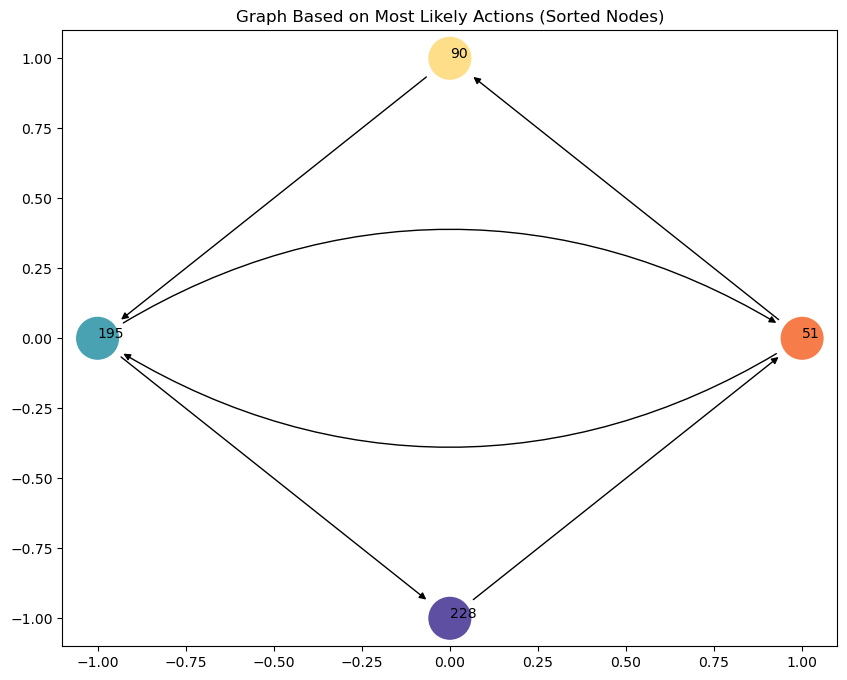

Sorted Node Labels: [ 51  90 195 228]
Normalized Combined Transition Matrix (Sorted):
 [[0.         0.54467356 0.45532647 0.        ]
 [0.         0.         1.         0.        ]
 [0.45360824 0.         0.         0.5463917 ]
 [1.         0.         0.         0.        ]]


TypeError: 'Graph' object is not iterable

In [178]:
# Visualize the learned, consolidated CSCG.

graph, states = plot_graph_probs(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf"
)

graph

In [53]:
A = T.sum(0)
A /= A.sum(1, keepdims=True)

NameError: name 'T' is not defined

In [159]:
states = chmm.decode(x, a)[1]
v = np.unique(states)
active_clones = v

In [160]:
T = chmm.C[:, v][:, :, v][:, 1:, 1:]

In [162]:
A = T.sum(0)
T, A

(array([[[  0., 317.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],
 
        [[  0.,   0.,   0.],
         [  0.,   0., 318.],
         [  0.,   0.,   0.]]], dtype=float32),
 array([[  0., 317.,   0.],
        [  0.,   0., 318.],
        [  0.,   0.,   0.]], dtype=float32))

In [36]:
states = chmm.decode(x, a)[1]
v = np.unique(states)
active_clones = v
T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
A = T.sum(0)
A /= A.sum(1, keepdims=True)
mess_fwd, E, T = get_mess_fwd(chmm, x, pseudocount_E=0.0001)

A, states.shape, active_clones

<ipython-input-36-6b8705582a3f>:6: RuntimeWarning: invalid value encountered in divide
  A /= A.sum(1, keepdims=True)


(array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], dtype=float32),
 (1000,),
 array([ 30, 108, 178, 183, 286]))

In [ ]:
x[:20], states[:20]

(array([0, 2, 3, 0, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1]),
 array([ 30, 183, 286,  30, 183, 286,  30, 183, 286,   2, 108, 286,   2,
        108, 286,   2, 108, 286,   2, 108]))

In [37]:
#Restrict Pi, T, and E matrices to active clones only.

num_active_clones = len(active_clones)

Pi_x_restricted = chmm.Pi_x[:num_active_clones]

T=chmm.T.copy()
T_restricted = np.zeros((T.shape[0], num_active_clones, num_active_clones))

for i in range(num_active_clones):
    for j in range(num_active_clones):
        original_i = active_clones[i]
        original_j = active_clones[j]
        T_restricted[:, i, j] = T[:, original_i, original_j]

clone_correspondence = {}
for i in range(num_active_clones):
    original_i = active_clones[i]
    clone_correspondence[i] = original_i


num_active_clones = len(active_clones)
E_restricted = np.zeros((num_active_clones, E.shape[1]))

for i in range(num_active_clones):
    original_i = clone_correspondence[i]
    E_restricted[i, :] = E[original_i, :]

In [39]:
#Check that the learned CSCG transition probs correspond to the ones used to generate the training sequence.

'''
Seuquence generation transition probabilities.
        [0.0, 0.7, 0.3, 0.0],   # Transition probabilities from S
        [0.0, 0.0, 0.3, 0.7],   # Transition probabilities from T
        [0.7, 0.0, 0.0, 0.3],   # Transition probabilities from C when arriving from T
        [0.0, 0.0, 0.0, 1.0],   # Transition probabilities from C when arriving from S
        [1.0, 0.0, 0.0, 0.0]    # Transition probabilities from A
'''

print("Learned transition probabilities from S:", T_restricted[0, 0, :])
print("Learned transition probabilities from T:", T_restricted[0, 1, :])
print("Learned transition probabilities from C when arriving from T:", T_restricted[0, 2, :])
print("Learned transition probabilities from C when arriving from S:", T_restricted[0, 3, :])
print("Learned transition probabilities from A:", T_restricted[0, 4, :])

#The learned probabilities are consistent with the given ones.

Learned transition probabilities from S: [6.14175224e-06 6.90953255e-01 6.14175224e-06 3.07093740e-01
 6.14175224e-06]
Learned transition probabilities from T: [8.86367798e-06 8.86367798e-06 2.88078368e-01 8.86367798e-06
 7.09103048e-01]
Learned transition probabilities from C when arriving from T: [5.94180346e-01 3.04692276e-05 3.04692276e-05 3.04692276e-05
 3.96130413e-01]
Learned transition probabilities from C when arriving from S: [2.00722607e-05 2.00722607e-05 2.00722607e-05 2.00722607e-05
 9.93596971e-01]
Learned transition probabilities from A: [9.97766078e-01 7.00181818e-06 7.00181818e-06 7.00181818e-06
 7.00181818e-06]


In [14]:
#Block transition from and to a specific node on the restricted T matrix.

T_restricted_blocked = T_restricted.copy()
clones_blocked_in_original = [108] #Starting node
clones_blocked_out_original = [286] #Ending node
idxs_blocked_in = []
idxs_blocked_out = []

for clone in clones_blocked_in_original:
  blocked_obs = clone//n_clones[0]
  for index, node in clone_correspondence.items():
    if node == clone:
      idxs_blocked_in.append(index)
      break

for clone in clones_blocked_out_original:
  blocked_obs = clone//n_clones[0]
  for index, node in clone_correspondence.items():
    if node == clone:
      idxs_blocked_out.append(index)
      break

for idx_blocked_in in idxs_blocked_in:
  for idx_blocked_out in idxs_blocked_out:
    T_restricted_blocked[:, idx_blocked_in, idx_blocked_out] = chmm.pseudocount
    T_restricted_blocked[:, idx_blocked_out, idx_blocked_in] = chmm.pseudocount

#T_restricted_blocked[T_restricted_blocked < 0.02] = 0

# Normalize to adjust probabilities
norm = T_restricted_blocked.sum(2, keepdims=True)
norm[norm == 0] = 1
T_restricted_blocked /= norm

norm = E.sum(1, keepdims=True)
norm[norm == 0] = 1
E /= norm

In [15]:
#Plot the updated graph, with the adjusted probabilities and blocked transitions.

def plot_graph_blocked(
    chmm, x, a, output_file, T_restricted_blocked, cmap=plt.cm.Spectral, multiple_episodes=False, vertex_size=30, edge_color='black', marked_transition=None
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(chmm.n_clones)[v]
    max_label = node_labels.max()
    colors = [cmap(nl / max_label)[:3] for nl in node_labels]

    edge_colors = ['black'] * len(g.es)

    if marked_transition is not None:
        source, target = marked_transition
        edge_idx = g.get_eid(source, target, directed=True, error=False)
        if edge_idx != -1:
            edge_colors[edge_idx] = 'red'


    # Define legend and layout (x, y spacing)
    category_ranges = np.linspace(0, max_label, 4)
    category_labels = ['Station', 'Train', 'Cab', 'Airport']
    legend_labels = []
    y_positions = {}
    base_y_coord = 0
    category_x_coords = {}
    x_spacing = 1000
    train_y_offset = -1
    cab_y_offset = -1
    for i, label in enumerate(category_labels):
        color = cmap(category_ranges[i] / max_label)[:3]
        legend_labels.append((label, color))
        category_x_coords[label] = i * x_spacing

    category_counts = {label: 0 for label in category_labels}
    node_categories = np.digitize(node_labels, category_ranges) - 1

    layout = []
    for idx, nl in enumerate(node_labels):
        category = category_labels[node_categories[idx]]
        x_coord = category_x_coords[category]
        # Adjust y-coordinates
        if category == "Train":
            y_coord = train_y_offset + (category_counts[category] * -1)
        elif category == "Cab":
            y_coord = cab_y_offset + (category_counts[category] * -1)
        else:
            y_coord = category_counts[category] *-1
        category_counts[category] -= 2
        layout.append((x_coord, y_coord))


    # Set edge labels based on transition probabilities
    for e in g.es:
        source = e.source
        target = e.target
        e['label'] = f"p={T_restricted_blocked[0, source, target]:.2f}"

    out = igraph.plot(
        g,
        None,
        layout=layout,
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
        edge_color=edge_colors,
        legend=legend_labels,
        legend_box=(1, 0),
    )

    legend_fig, legend_ax = plt.subplots(figsize=(2, 2))
    legend_ax.axis('off')
    legend_ax.legend(handles=[Line2D([0], [0], marker='o', color='w', label=label,
                                      markerfacecolor=color, markersize=10)
                              for label, color in legend_labels],
                     loc='center')
    plt.show()
    legend_fig.show()

    return out, states

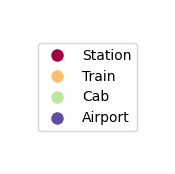

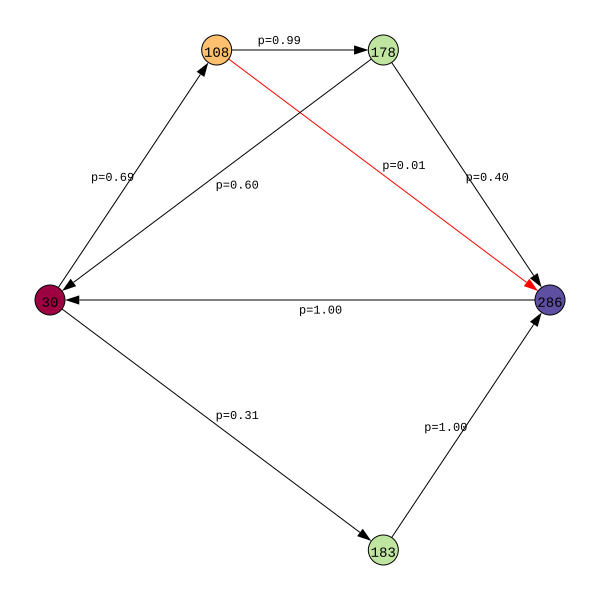

In [17]:
output_file = "figures/CSCG_for_counterfactual_causal_basic.png"
plot_result, states = plot_graph_blocked(chmm, x, a, output_file, T_restricted_blocked, marked_transition=(1, 4))
plot_result.save(output_file)
plot_result




In [189]:
states = chmm.decode(x, a)[1]
v = np.unique(states)
T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
v = v[1:]

In [192]:
states = chmm.decode(x, a)[1]
v = np.unique(states)
v

array([ 51,  90, 195, 228])

In [17]:
states[:20], x[:20]

(array([ 51, 168,  51,  90, 173,  51, 168,  51, 168, 263,  51, 168, 263,
         51,  90, 173,  51, 168, 263,  51]),
 array([0, 2, 0, 1, 2, 0, 2, 0, 2, 3, 0, 2, 3, 0, 1, 2, 0, 2, 3, 0]))

In [190]:
# Find indices where x has 0 followed by 1
T_from_L_idxs = [i for i in range(len(x) - 1) if x[i] == 2 and x[i -1] == 1]
T_from_S_idxs = [i for i in range(len(x) - 1) if x[i] == 2 and x[i -1] == 0]

len(T_from_L_idxs), len(T_from_S_idxs)

(317, 265)

In [191]:
np.sum(states[T_from_L_idxs]==195), np.sum(states[T_from_L_idxs]==228),  np.sum(states[T_from_S_idxs]==195), np.sum(states[T_from_S_idxs]==168), 

(317, 0, 265, 0)

In [70]:
len([i for i, val in enumerate(states) if val == 181]), len([i for i, val in enumerate(states) if val == 168])

(209, 385)